# Initial Python Setup
First, we'll need to import the related libraries that will be used in this scirpt


In [1]:
import os
import pandas as pd
import requests as req
import numpy as np
import statsmodels.api as stapi
import statsmodels.formula.api as smf
import scipy.stats as st

from pandas import DataFrame
from zipfile import ZipFile
from io import BytesIO
from IPython.display import display
from matplotlib import rc as pltrc
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import RegressionResults, RegressionResultsWrapper

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Next, we'll set up some initial variables and configuration, such as links and display options


In [2]:
url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
file_name = 'survey_results_public.csv'

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

pltrc('font', size=10)

# Importing the Dataset
Here, we will download and extract the dataset. We'll be doing the entire process in-memory, so you will not need to worry about any additional files being saved to your computer

In [3]:
response = req.get(url)
zip_file = ZipFile(BytesIO(response.content))
df = pd.read_csv(BytesIO(zip_file.read(file_name)))

Now, the dataframe is stored in the `df` variable, and looks like the following:

In [4]:
display(df)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,None of these,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",Fully remote,Hobby;Contribute to open-source projects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,CAD\tCanadian dollar,NaN,NaN,JavaScript;TypeScript,Rust;TypeScript,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,macOS,Windows Subsystem for Linux (WSL),Git,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Very unfavorable,Collectives on Stack Overflow;Stack Overflow f...,Daily or almost daily,Yes,Daily or almost daily,Not sure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Difficult,NaN
2,3,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Friend or family member...,Technical documentation;Blogs;Programming Game...,NaN,14,5,Data scientist or machine learning specialist;...,20 to 99 employees,I have some influence,NaN,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,32000.0,Yearly,C#;C++;HTML/CSS;JavaScript;Python,C#;C++;HTML/CSS;JavaScript;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,Angular.js,Angular;Angular.js,Pandas,.NET,NaN,NaN,Notepad++;Visual Studio,Notepad++;Visual Studio,Windows,Windows,Git,Code editor,NaN,NaN,NaN,NaN,Microsoft Teams,Microsoft Teams,Very unfavorable,Collectives on Stack Overflow;Stack Overflow;S...,Multiple times per day,Yes,Multiple times per day,Neutral,25-34 years old,Man,No,Bisexual,White,None of the above,"I have a mood or emotional disorder (e.g., dep...",No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Neither easy nor difficult,40205.0
3,4,I am a developer by profession,"Employed, full-time",Fully remote,I don’t code outside of work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Books / Physical media;School (i.e., Universit...",NaN,NaN,20,17,"Developer, full-stack",100 to 499 employees,I have some influence,Other (please specify):,Israel,ILS\tIsraeli new shekel,60000.0,Monthly,C#;JavaScript;SQL;TypeScript,C#;SQL;TypeScript,Microsoft SQL Server,Microsoft SQL Server,NaN,NaN,ASP.NET;ASP.NET Core,ASP.NET;ASP.NET Core,.NET,.NET,NaN,NaN,Notepad++;Visual Studio;Visual Studio Code,Notepad++;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Jira Work Management;Trello,Jira Work Management;Trello,Slack;Zoom

# Data Cleaning
Now, the data won't work in the original state. As stated in the report, many of the variables are actually multi-selectable lists. The variables are stored as strings, using `;` as a separator.

We'll create new dataframes for each of these. In this step, we'll also need to rename some of the new columns to avoid including spaces or characters we can't use in regression.

In [5]:
df_languages = df["LanguageHaveWorkedWith"].str.get_dummies(';').rename(columns={
  "C#": "CSharp",
  "F#": "FSharp",
  "Bash/Shell": "Bash",
  "HTML/CSS": "HTML",
  "Objective-C": "ObjectiveC",
  "C++": "Cpp"
}).add_prefix("WorksIn_")

df_devtype = df["DevType"].str.get_dummies(";").rename(columns={
  "Academic researcher": "AcademicResearcher",
  "Cloud infrastructure engineer": "CloudInfrastructureEngineer",
  "Data or business analyst": "DataBusinessAnalyst",
  "Data scientist or machine learning specialist": "DataScientistMachineLearning",
  "Database administrator": "DatabaseAdministrator",
  "DevOps specialist": "DevOpsSpecialist",
  "Developer, QA or test": "DevQATest",
  "Developer, back-end": "DevBackend",
  "Developer, desktop or enterprise applications": "DevDesktopApps",
  "Developer, embedded applications or devices": "DevEmbedded",
  "Developer, front-end": "DevFrontend",
  "Developer, full-stack": "DevFullstack",
  "Developer, game or graphics": "DevGame",
  "Developer, mobile": "DevMobile",
  "Engineer, data": "DataEngineer",
  "Engineer, site reliability": "SiteReliabilityEngineer",
  "Engineering manager": "EngineerManager",
  "Marketing or sales professional": "MarketingSales",
  "Other (please specify):": "Other",
  "Product manager": "ProductManager",
  "Project manager":"ProjectManager",
  "Security professional": "Security",
  "Senior Executive (C-Suite, VP, etc.)": "SeniorExec",
  "System administrator": "SystemAdmin"
}).add_prefix("DevType_")
df_employment = df["Employment"].str.get_dummies(";").rename(columns={
  "Employed, full-time": "FullTime",
  "Employed, part-time": "PartTime",
  "I prefer not to say": "Unknown",
  "Independent contractor, freelancer, or self-employed": "SelfEmployed",
  "Not employed, and not looking for work": "UnemployedNotLooking",
  "Not employed, but looking for work": "UnemployedLooking",
  "Student, full-time": "StudentFullTime",
  "Student, part-time": "StudentPartTime"
}).add_prefix("Employed_")
df_education = df["EdLevel"].str.get_dummies(";").rename(columns = {
  "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "MastersDegree",
  "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "BachelorsDegree",
  "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "SecondarySchool",
  "Some college/university study without earning a degree": "SomeCollege",
  "Something else": "SomethingElse",
  "Primary/elementary school": "PrimarySchool",
  "Other doctoral degree (Ph.D., Ed.D., etc.)": "DoctoralDegree",
  "Associate degree (A.A., A.S., etc.)": "AssociatesDegree",
  "Professional degree (JD, MD, etc.)": "ProfessionalDegree"
}).add_prefix("Education_")

del df_education["Education_SecondarySchool"]
del df_education["Education_PrimarySchool"]
del df_education["Education_SomeCollege"]

Each of these dataframes contain a column for every possible choice found in the dataset. For example, the `dummy_languages` contains each of the languages found in the dataset as follows:

In [6]:
display(df_languages)

,WorksIn_APL,WorksIn_Assembly,WorksIn_Bash,WorksIn_C,WorksIn_CSharp,WorksIn_Cpp,WorksIn_COBOL,WorksIn_Clojure,WorksIn_Crystal,WorksIn_Dart,WorksIn_Delphi,WorksIn_Elixir,WorksIn_Erlang,WorksIn_FSharp,WorksIn_Fortran,WorksIn_Go,WorksIn_Groovy,WorksIn_HTML,WorksIn_Haskell,WorksIn_Java,WorksIn_JavaScript,WorksIn_Julia,WorksIn_Kotlin,WorksIn_LISP,WorksIn_Lua,WorksIn_MATLAB,WorksIn_OCaml,WorksIn_ObjectiveC,WorksIn_PHP,WorksIn_Perl,WorksIn_PowerShell,WorksIn_Python,WorksIn_R,WorksIn_Ruby,WorksIn_Rust,WorksIn_SAS,WorksIn_SQL,WorksIn_Scala,WorksIn_Solidity,WorksIn_Swift,WorksIn_TypeScript,WorksIn_VBA
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73263,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0
73264,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
73265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
73266,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


If the person indicated that they have worked with the language, there will be a `1`. Otherwise, there will be a `0`.

Now, we can simply overwrite `df` to append these sub-dataframes into the main dataframe

In [7]:
df = pd.concat([df,df_languages, df_devtype, df_employment, df_education], axis = 1)

Next, some of the numeric columns have entries for extremities. For example, the `YearsCode` column can have the value `"Less than 1 year"` or `"More than 50 years"`, which can be problematic if we try to use them in our regression.

For simplification, we'll assume that `"Less than 1 year"` is `0`, and `"More than 50 years"` is `50`


In [8]:
df["NumYearsCode"] = pd.to_numeric(
  df["YearsCode"].replace({
    "Less than 1 year": 0,
    "More than 50 years": 50
  })
)

df["NumYearsCodePro"] = pd.to_numeric(
  df["YearsCodePro"].replace({
    "Less than 1 year": 0,
    "More than 50 years": 50
  })
)

Similarly, the text data for education level is bloated, so we will be replacing those in order to make our regression outputs cleaner

# Filtering Data
Not all of the data can be useful to us. Entries come from across the world, get paid in different currencies, and not to mention some may put in false information. 

In order to get a dataset we can reliably use, we will first restrict our analysis on individuals in the United States. 

Next, we'll only use individuals who have the `"ConvertedCompYearly"` variable filled in. It appears that some of the outlier do not have this variable, so it may be StackOverflow's filtering to remove significant outliers

We will also remove any entries with any "unknown" values, such as having an unknown employment status

In [9]:
df_filtered = df[
  (df["Country"] == "United States of America") & 
  (df["ConvertedCompYearly"].notna()) &
  (df["ConvertedCompYearly"] < 1000000) &
  (df["Employed_Retired"] == 0) &
  (df["Education_SomethingElse"] == 0) &
  (df["DevType_Other"] == 0)
]
if "Education_SomethingElse" in list(df_education.columns):
  del df_education["Education_SomethingElse"]
if "DevType_Other" in list(df_devtype.columns):
  del df_devtype["DevType_Other"]
if "Employed_Retired" in list(df_employment.columns):
  del df_employment["Employed_Retired"]

Our data is now filtered properly, and ready to be analyzed

In [10]:
display(df_filtered)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly,WorksIn_APL,WorksIn_Assembly,WorksIn_Bash,WorksIn_C,WorksIn_CSharp,WorksIn_Cpp,WorksIn_COBOL,WorksIn_Clojure,WorksIn_Crystal,WorksIn_Dart,WorksIn_Delphi,WorksIn_Elixir,WorksIn_Erlang,WorksIn_FSharp,WorksIn_Fortran,WorksIn_Go,WorksIn_Groovy,WorksIn_HTML,WorksIn_Haskell,WorksIn_Java,WorksIn_JavaScript,WorksIn_Julia,WorksIn_Kotlin,WorksIn_LISP,WorksIn_Lua,WorksIn_MATLAB,WorksIn_OCaml,WorksIn_ObjectiveC,WorksIn_PHP,WorksIn_Perl,WorksIn_PowerShell,WorksIn_Python,WorksIn_R,WorksIn_Ruby,WorksIn_Rust,WorksIn_SAS,WorksIn_SQL,WorksIn_Scala,WorksIn_Solidity,WorksIn_Swift,WorksIn_TypeScript,WorksIn_VBA,DevType_AcademicResearcher,DevType_Blockchain,DevType_CloudInfrastructureEngineer,DevType_DataBusinessAnalyst,DevType_DataScientistMachineLearning,DevType_DatabaseAdministrator,DevType_Designer,DevType_DevOpsSpecialist,DevType_DevQATest,DevType_DevBackend,DevType_DevDesktopApps,DevType_DevEmbedded,DevType_DevFrontend,DevType_DevFullstack,DevType_DevGame,DevType_DevMobile,DevType_Educator,DevType_DataEngineer,DevType_SiteReliabilityEngineer,DevType_EngineerManager,DevType_MarketingSales,DevType_Other,DevType_ProductManager,DevType_ProjectManager,DevType_Scientist,DevType_Security,DevType_SeniorExec,DevType_Student,DevType_SystemAdmin,Employed_FullTime,Employed_PartTime,Employed_Unknown,Employed_SelfEmployed,Employed_UnemployedNotLooking,Employed_UnemployedLooking,Employed_Retired,Employed_StudentFullTime,Employed_StudentPartTime,Education_AssociatesDegree,Education_BachelorsDegree,Education_MastersDegree,Education_DoctoralDegree,Education_ProfessionalDegree,Education_SomethingElse,NumYearsCode,NumYearsCodePro
11,12,"I am not primarily a developer, but I write co...","Employed, full-time;Independent contractor, fr...",Fully remote,Hobby;Contribute to open-source projects;Freel...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,NaN,12,10,Engineering manager,20 to 99 employees,I have some influence,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,194400.0,Yearly,C#;HTML/CSS;JavaScript;PowerShell;Python;Rust;SQL,C++;Go;HTML/CSS;JavaScript;Lua;Rust;TypeScript,Couchbase;CouchDB;Microsoft SQL Server;MongoDB...,Elasticsearch;MongoDB;Redis;SQLite,AWS;Microsoft Azure,AWS;DigitalOcean;Firebase;Linode,ASP.NET;ASP.NET Core ;Express;Node.js;Vue.js,ASP.NET Core ;Node.js;Nuxt.js;React.js;Vue.js,.NET;Keras;NumPy;Pandas;Scikit-learn;TensorFlo...,Keras;NumPy;Pandas;Scikit-learn;TensorFlow;Tor...,Docker;Homebrew;Kubernetes,Docker;Homebrew;Kubernetes;Pulumi;Terraform,IPython/Jupyter;Neovim;Visual Studio;Visual St...,IPython/Jupyter;Neovim;Visual Studio Code,Linux-based;macOS;Windows,Linux-based;macOS,Git,Code editor;Dedicated ve

# Helper Functions

To make things easier, I'll create a bunch of functions here that help automate the displaying of plots (which can be copied into the report).



This function helps us by simply removing the first section of our new variables (so `WorksIn_Python` results in `Python`)


In [11]:
def removePrefix(string: str):
  return string[string.find('_')+1:]

This function will help visualize the effects of each column. By default, it will be set to show the languages, but it is configurable for my needs further on

In [12]:
def showCoefficientGraph(
    regression: RegressionResultsWrapper, 
    columns: list[str] = list(df_languages.columns),
    fig_size = (30,10),
    y_scale_factor = 1,
    ylabel="Coefficient",
    xlabel="Variable",
    remove_underscore = True,
    replace_underscore_with_space = True,
    font_size=20,
    title="Variable Coefficients",
    rotate_xticks = -90,
    show_stddev = False,
    show_grid = True,
    tick_scale = 10.0,
    scale = True,
    min_val = None,
    max_val = None,
  ):



  reg: RegressionResults = regression #type: ignore
  table: pd.DataFrame = reg.summary2().tables[1]
  table = table[table.index.isin(columns)]
  if show_stddev:
    table["Coef."] = np.abs(table["Coef."] / table["Std.Err."])
  table = table.sort_values(by=["Coef."])
  
  
  if remove_underscore:
    table = table.set_axis([removePrefix(axis) for axis in list(table.index)], axis='index')
  elif replace_underscore_with_space:
    table = table.set_axis([axis.replace('_',' ') for axis in list(table.index)], axis='index')

  pltrc('font', size=font_size)
  plt.figure(figsize = fig_size)
  plt.xticks(rotation=rotate_xticks)
  barcontainer = plt.bar(table.index,table["Coef."] * y_scale_factor)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)

  values = table["Coef."] * y_scale_factor

  mn = (int(min(values)) // tick_scale) * tick_scale - tick_scale
  mx = (int(max(values)) // tick_scale) * tick_scale + tick_scale

  if scale:
    plt.yticks(np.arange(mn if min_val == None else min_val, (mx if max_val == None else max_val)+1, tick_scale))

  if title:
    plt.title(title)
  
  if show_grid:
    plt.grid(color='black', linestyle=':', linewidth=2, axis='y', alpha=0.7)

  if show_stddev:
    for a,color in [(0.90,'red'),(0.95,'green'),(0.99,'purple')]:
      plt.axhline(y = st.norm.interval(confidence=a)[1], label = f'{a * 100}% Confidence Interval', color=color)
    plt.legend(loc='upper left')

  return plt


Similarly, we'll need a function to display the summary (with additional features)

In [13]:
def display_summary(
    regression: RegressionResultsWrapper, 
    remove_underscore = True,
    replace_underscore_with_space = True,
  ):
  reg: RegressionResults = regression #type: ignore
  tables = reg.summary2().tables
  table: pd.DataFrame = tables[1]

  if remove_underscore:
    table = table.set_axis([removePrefix(axis) for axis in list(table.index)], axis='index')
  elif replace_underscore_with_space:
    table = table.set_axis([axis.replace('_',' ') for axis in list(table.index)], axis='index')

  return table
  

Additionally, we'll make a function that will export the table into a latex longtable

In [14]:
def to_longtable(
    table: pd.DataFrame,
    cols: list[str] = ["index", "Coef.", "Std.Err."],
    width: list[float] = [0.4,0.3,0.3],
  ):
  df: DataFrame = table

  if "index" in cols:
    df.reset_index(inplace=True)
    df["index"] = [removePrefix(item) for item in df["index"]]

  # df = df.set_axis([removePrefix(axis) for axis in list(df.index)], axis='index')
  

  columns = [table[col] for col in cols]

  bs = chr(92)
  nl = '\n'

  def format(item):
    if type(item) in [int, str, np.float64, np.float32, np.float16, np.int64, np.int32, np.int16]:
      return f'${item}$'
    else:
      return str(item)

  return (
f"""{bs}begin{{longtable}}{{|{'|'.join([f'R{{{d}{bs}linewidth}}' for d in width])}|}}
{bs}hline
{' & '.join([f'{bs}textbf{{{name if name != "index" else "Coefficient"}}}' for name in cols])} {bs}{bs}

{bs}hline
{f"{bs}{bs}{nl}{bs}hline{nl}".join([
  ' & '.join([format(col[i]) for col in columns])
  for i in range(len(columns[0]))
])} {bs}{bs}
{bs}hline
{bs}end{{longtable}}
"""
  )
  

We'll also need to be able to get the columns from the sub-dataframes

In [15]:
def cols(df: pd.DataFrame) -> list[str]:
  return list(df.columns)

And a way to join them into a `" + "` separated string

In [16]:
def add(vals: list[str]) -> str:
  return " + ".join(vals)

# Inspecting Data Distribution

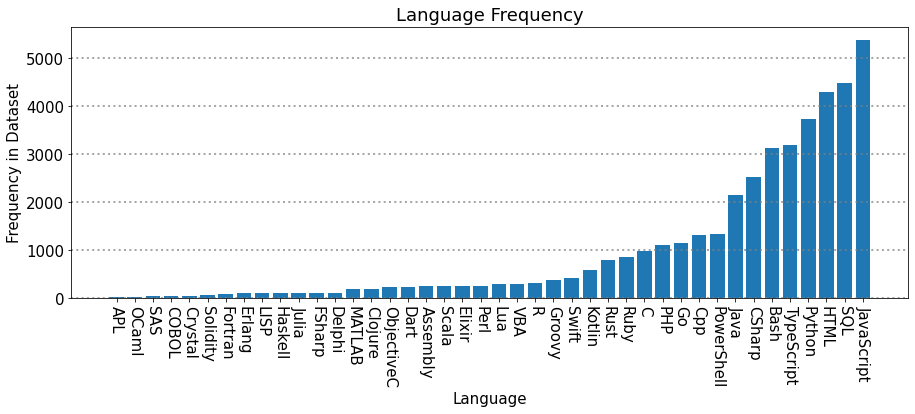

In [17]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_languages)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Language Frequency")
plt.xlabel("Language")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

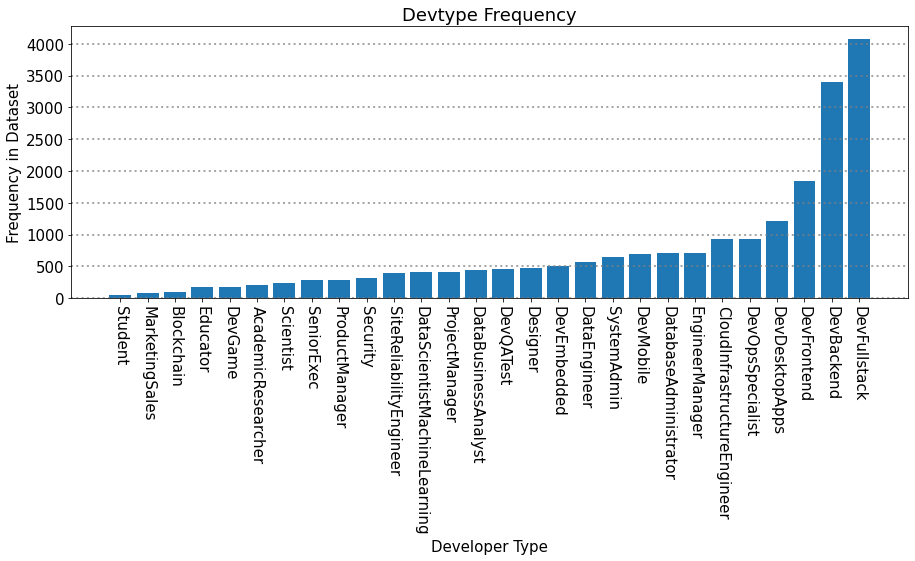

In [18]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_devtype)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Devtype Frequency")
plt.xlabel("Developer Type")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

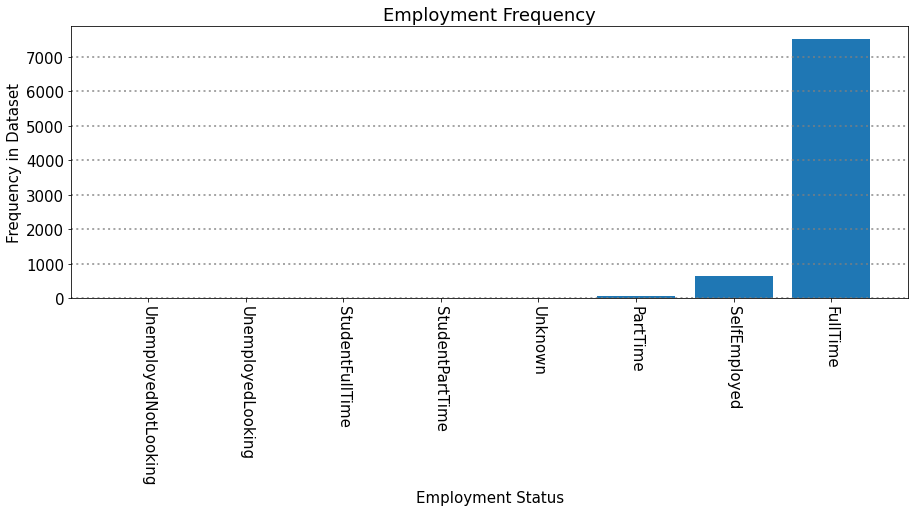

In [19]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_employment)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Employment Frequency")
plt.xlabel("Employment Status")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

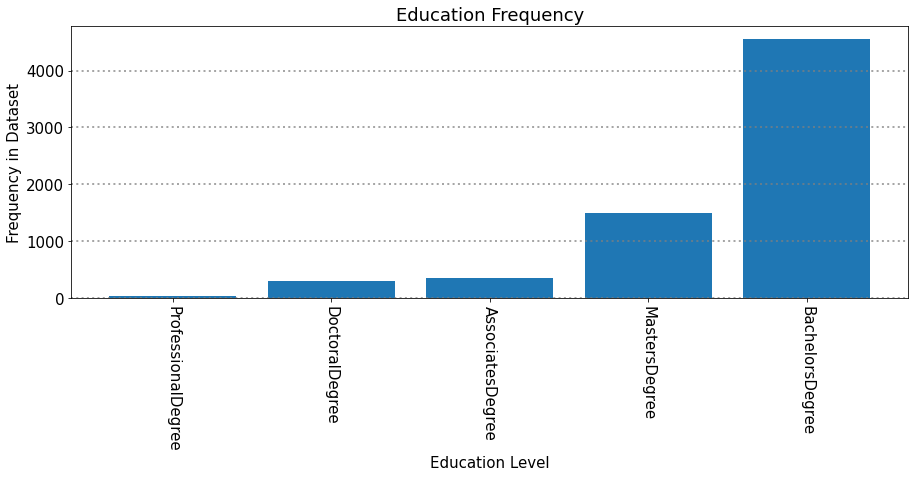

In [20]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
df_dist = df_filtered[cols(df_education)].sum().sort_values()
df_dist = df_dist.set_axis([removePrefix(axis) for axis in list(df_dist.index)], axis='index')
plt.title("Education Frequency")
plt.xlabel("Education Level")
plt.ylabel("Frequency in Dataset")
plt.xticks(rotation=-90)
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.bar(df_dist.index, df_dist)
plt.show()

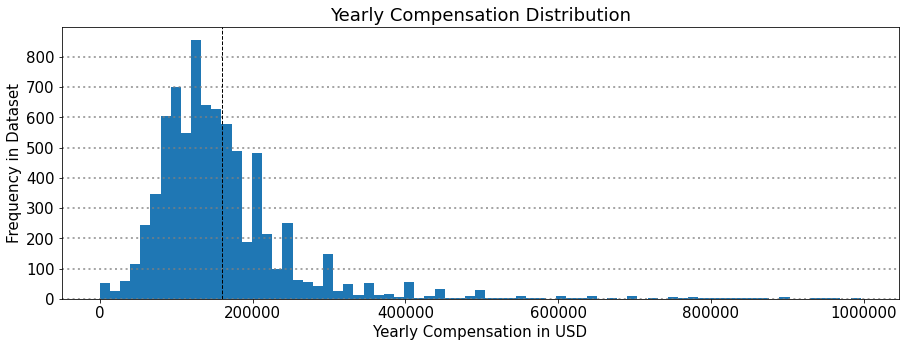

In [21]:
# Create a distribution plot for ConvertdCompYearly
pltrc('font', size=15)
plt.figure(figsize = (15,5))
plt.title("Yearly Compensation Distribution")
plt.xlabel("Yearly Compensation in USD")
plt.ylabel("Frequency in Dataset")
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.hist(df_filtered["ConvertedCompYearly"], bins=75)
plt.axvline(df_filtered["ConvertedCompYearly"].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ticklabel_format(style='plain', axis='x')
plt.show()


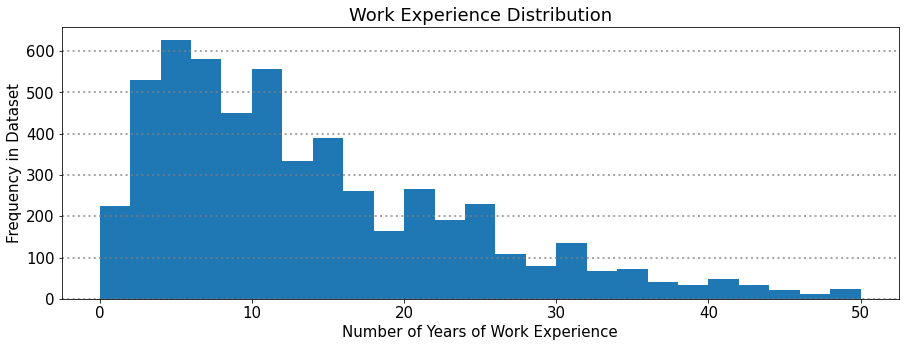

In [22]:
pltrc('font', size=15)
plt.figure(figsize = (15,5))
plt.title("Work Experience Distribution")
plt.xlabel("Number of Years of Work Experience")
plt.ylabel("Frequency in Dataset")
plt.grid(color='grey', linestyle=':', linewidth=2, axis='y', alpha=0.7)
plt.hist(df_filtered["WorkExp"], bins=25)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Analysis
Now, we get into the fun part. I won't have much of the explanation here, since that's the purpose of the report. However, I'll try to include a basic idea of what each part is


In [23]:
model = ols(f"""np.log10(ConvertedCompYearly) ~ {add(
  cols(df_languages) +
  cols(df_devtype) + 
  cols(df_education) +
  ['WorkExp']
)}""", data = df_filtered).fit()

In [24]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
=====================================================================================
Model:                OLS                             Adj. R-squared:       0.118    
Dependent Variable:   np.log10(ConvertedCompYearly)   AIC:                  1065.1047
Date:                 2022-12-17 20:15                BIC:                  1574.0432
No. Observations:     5484                            Log-Likelihood:       -455.55  
Df Model:             76                              F-statistic:          10.63    
Df Residuals:         5407                            Prob (F-statistic):   5.78e-113
R-squared:            0.130                           Scale:                0.070116 
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------------------
Intercept                             5.0186   0.0148 338.2007 0.0000  4.9895  5.0477
WorksIn_APL                          -0.0845   0.0703  -1.2017 0.2295 -0.2223  0.0533
WorksIn_Assembly                      0.0165   0.0232   0.7124 0.4763 -0.0290  0.0621
WorksIn_Bash                          0.0225   0.0081   2.7691 0.0056  0.0066  0.0384
WorksIn_C                            -0.0046   0.0142  -0.3265 0.7441 -0.0324  0.0232
WorksIn_CSharp                       -0.0126   0.0091  -1.3857 0.1659 -0.0304  0.0052
WorksIn_Cpp                           0.0013   0.0119   0.1117 0.9111 -0.0220  0.0247
WorksIn_COBOL                        -0.0598   0.0459  -1.3035 0.1925 -0.1497  0.0301
WorksIn_Clojure                       0.0564   0.0246   2.2890 0.0221  0.0081  0.1047
WorksIn_Crystal                      -0.0723   0.0433  -1.6718 0.0946 -0.1572  0.0125
WorksIn_Dart                         -0.0092   0.0219  -0.4190 0.6752 -0.0521  0.0337
WorksIn_Delphi                       -0.0694   0.0359  -1.9349 0.0531 -0.1397  0.0009
WorksIn_Elixir                        0.0221   0.0247   0.8961 0.3702 -0.0263  0.0705
WorksIn_Erlang                        0.0247   0.0387   0.6372 0.5240 -0.0512  0.1005
WorksIn_FSharp                        0.0032   0.0292   0.1086 0.9136 -0.0540  0.0604
WorksIn_Fortran                      -0.0483   0.0411  -1.1772 0.2392 -0.1288  0.0322
WorksIn_Go                            0.0534   0.0110   4.8607 0.0000  0.0318  0.0749
WorksIn_Groovy                        0.0016   0.0175   0.0916 0.9270 -0.0327  0.0359
WorksIn_HTML                         -0.0280   0.0091  -3.0793 0.0021 -0.0459 -0.0102
WorksIn_Haskell                       0.0084   0.0319   0.2632 0.7924 -0.0542  0.0710
WorksIn_Java                          0.0194   0.0089   2.1781 0.0294  0.0019  0.0368
WorksIn_JavaScript                   -0.0027   0.0102  -0.2677 0.7889 -0.0228  0.0173
WorksIn_Julia                        -0.0155   0.0353  -0.4385 0.6610 -0.0848  0.0538
WorksIn_Kotlin                        0.0105   0.0147   0.7190 0.4722 -0.0182  0.0393
WorksIn_LISP                         -0.0175   0.0330  -0.5302 0.5960 -0.0821  0.0471
WorksIn_Lua                          -0.0308   0.0206  -1.4985 0.1341 -0.0712  0.0095
WorksIn_MATLAB                       -0.0212   0.0250  -0.8485 0.3962 -0.0702  0.0278
WorksIn_OCaml                         0.0502   0.0672   0.7465 0.4554 -0.0816  0.1819
WorksIn_ObjectiveC                    0.0722   0.0248   2.9107 0.0036  0.0236  0.1209
WorksIn_PHP                          -0.0544   0.0111  -4.8851 0.0000 -0.0763 -0.0326
WorksIn_Perl                         -0.0061   0.0206  -0.2961 0.7672 -0.0465  0.0343
WorksIn_PowerShell                   -0.0141   0.0104  -1.3621 0.1732 -0.0345  0.0062
WorksIn_Python                        0.0027   0.0082   0.3297 0.7416 -0.0133  0.0187
WorksIn_R                            -0.0303   0.0209  -1.4458 0.1483 -0.0713  0.0108
WorksIn_Ruby          

In [25]:
print(to_longtable(model.summary2().tables[1]))

\begin{longtable}{|R{0.4\linewidth}|R{0.3\linewidth}|R{0.3\linewidth}|}
\hline
\textbf{Coefficient} & \textbf{Coef.} & \textbf{Std.Err.} \\

\hline
$Intercept$ & $5.018561975617827$ & $0.014839004672467472$\\
\hline
$APL$ & $-0.08449616172936489$ & $0.07031461604245251$\\
\hline
$Assembly$ & $0.016543407577874203$ & $0.023222811832528233$\\
\hline
$Bash$ & $0.022502299799285364$ & $0.008126254562779637$\\
\hline
$C$ & $-0.004627316713939622$ & $0.014173655368536292$\\
\hline
$CSharp$ & $-0.012588890609753975$ & $0.009085160939920714$\\
\hline
$Cpp$ & $0.0013302181178897199$ & $0.011912263426960995$\\
\hline
$COBOL$ & $-0.05980366511464108$ & $0.045879491473421935$\\
\hline
$Clojure$ & $0.05637302678016759$ & $0.024627811466780104$\\
\hline
$Crystal$ & $-0.07234531945106182$ & $0.04327405939866166$\\
\hline
$Dart$ & $-0.00917484299525742$ & $0.02189492641781949$\\
\hline
$Delphi$ & $-0.0693890922496736$ & $0.03586179425005313$\\
\hline
$Elixir$ & $0.02210851459062957$ & $0.0246722922760

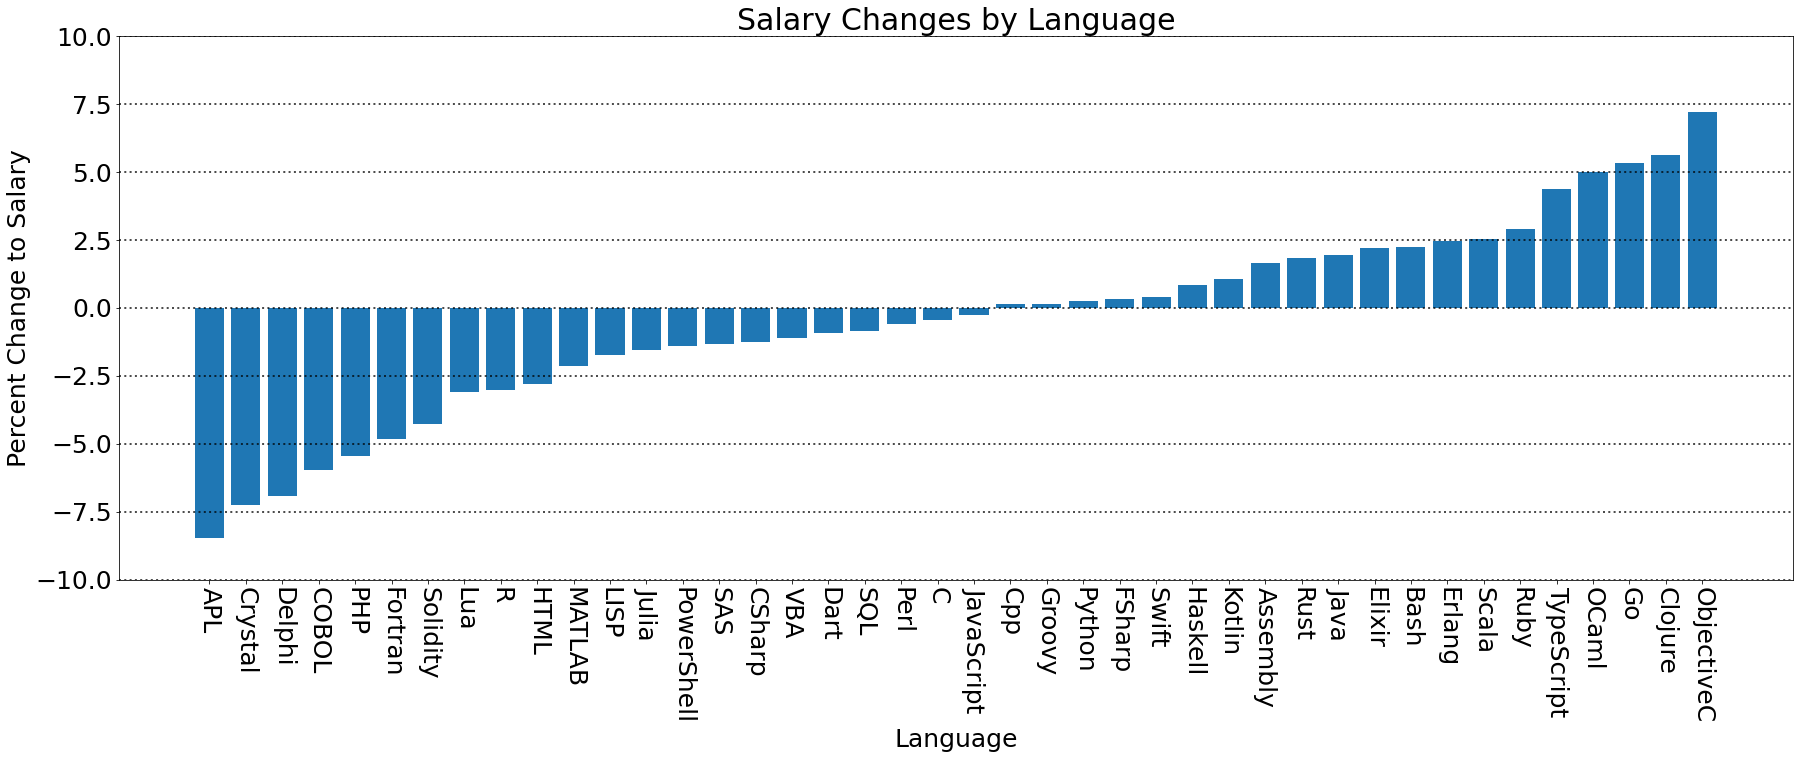

In [26]:
showCoefficientGraph(
  model,
  columns=cols(df_languages),
  y_scale_factor=100,
  max_val=10,
  min_val=-10,
  tick_scale=2.5,
  xlabel="Language",
  ylabel="Percent Change to Salary",
  title="Salary Changes by Language",
  font_size=25
).show()

def showCoefficientGraph(
    regression: RegressionResultsWrapper, 
    columns: list[str] = list(df_languages.columns),
    fig_size = (30,10),
    y_scale_factor = 1,
    ylabel="Coefficient",
    xlabel="Variable",
    remove_underscore = True,
    replace_underscore_with_space = True,
    font_size=20,
    title="Variable Coefficients",
    rotate_xticks = -90,
    show_stddev = False,
    show_grid = True,
    tick_scale = 10,
    scale = True

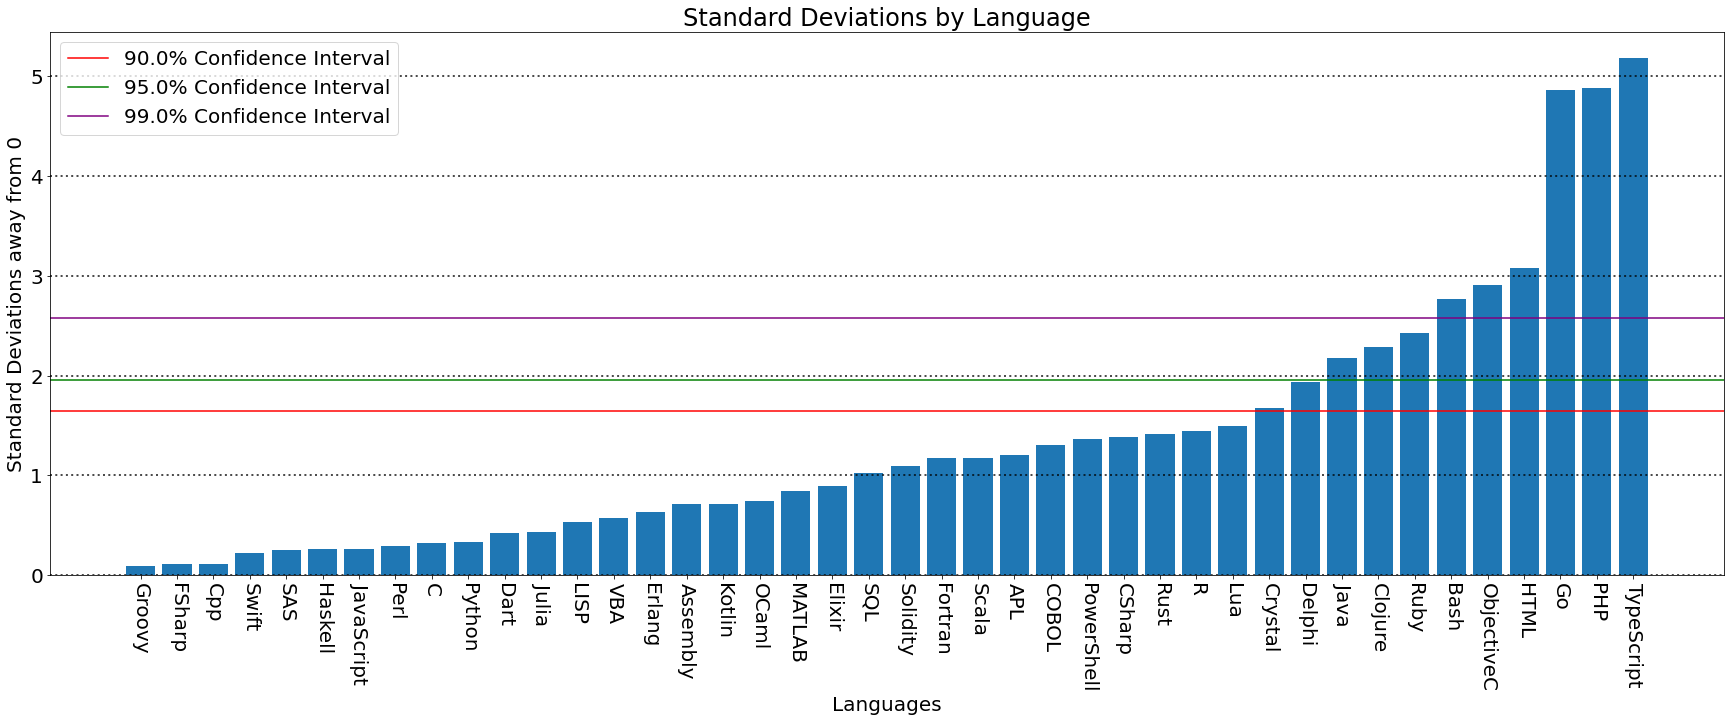

In [27]:
showCoefficientGraph(
  model,
  columns = cols(df_languages),
  scale=False,
  show_stddev=True,
  xlabel="Languages",
  ylabel="Standard Deviations away from 0",
  title="Standard Deviations by Language"
).show()